<Center>
<b>Assignment 1: </b><br> 
Cornelis de Jager n8891974 <br>
Daniel Brandenburg n8867887 <br>
Joel Schwaber n10241337 
</center>

In [4]:
# Run this if pydot needs to be installed
#!pip install imblearn

  Running setup.py bdist_wheel for tabulate: started
  Running setup.py bdist_wheel for tabulate: finished with status 'done'
  Stored in directory: C:\Users\n8891974\AppData\Local\pip\Cache\wheels\2b\67\89\414471314a2d15de625d184d8be6d38a03ae1e983dbda91e84
Successfully built tabulate


In [169]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

# Import ML libraries
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Set a random state value
rs = 10

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [170]:
def categoricalPlot(cat, cat2 = 'IsBadBuy'): # Cat is the carigorical as a string i.e 'Size'
    pd.crosstab(data[cat],data[cat2]).plot(kind="bar")

def IdentifyOutliers (column):
    data_described = column.describe()
    Q1 = data_described["25%"]
    Q3 = data_described["75%"]
    IQR = Q3-Q1
    lowerLimit = Q1 - 1.5 * IQR
    upperLimit = Q3 + 1.5 * IQR
    output = [np.nan] * len( column )
    for i in range(len(column)):
        value = column[i]
        if value < lowerLimit or value > upperLimit:
            output[i] = True
        else:
            output[i] = False
    return output

def analyse_feature_importance(dm_model, feature_names, n_to_display=5):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])
        
# Define a function to find the root node
def getTreeInfo(model, feature_names):
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    features  = [feature_names[i] for i in model.tree_.feature]    

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    leaf_count = 0
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
        
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_count += 1
            is_leaves[node_id] = True


    main_variables = "Root feature is " 
    main_variables += features[0]
    main_variables += "\n"
    main_variables += "Competing featues are "
    main_variables += features[1]
    main_variables += 'and '
    main_variables += features[2]
    return [n_nodes, leaf_count, main_variables]
    
# Write a function that imputes median
def ImputeMean(series):
    return series.fillna(series.mean())

def Normalize (column):
    column =  (column - column.min())/(column.max() - column.min())
    return column

def LogTransform (column):
    column = math.log(column)

In [171]:
def PreProcessing (data):
    print("Pre-Processing Step")
    
    # Check if there are any missing target variables
    if data['IsBadBuy'].isna().any():
        print("Missing Target Variables")
    else:
        print("No missing Target Variables")
    
    
    # Handle Bad Columns drop Columns
    data.drop(['PRIMEUNIT', 'AUCGUART', 'WheelTypeID', 'ForSale', 'PurchaseDate', 'IsOnlineSale'], 
              axis=1, 
              inplace=True)
    

    # Handle Missing Values
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Hyundai':
            data['TopThreeAmericanName'][i] = 'HYUNDAI'
        i += 1
        
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Jeep':
            data['TopThreeAmericanName'][i] = 'JEEP'
        i += 1
        
        
    # Standardise the capitilization across all object rows
    obj_cols = data.select_dtypes(include='object').columns # Create a list of col names
    for i in obj_cols:              # Interate over the obj_cols list
        data[i] = data[i].str.upper()   # Convert all strings to uppercase  
    # Standardize USA to AMERICA
    data['Nationality'].replace({'USA' : 'AMERICAN'}, inplace = True)
    
    # Turn Transmission into a binary variable with Auto = 1 and Manual = 0
    data.rename({'Transmission' : 'Auto'}, axis = 1, inplace = True)
    # Replace binary columns with 1s and 0s
    data['Auto'].replace({'MANUAL' : 0, 'AUTO' : 1}, inplace=True)
    
    # Remove NOT AVAIL in color and place it in the NaN section
    data['Color'].replace({'NOT AVAIL': np.nan}, inplace = True)
    
    
     #This is the significance test for 
    # Check to see if VNST is a statisically significant variable
    # Create a distribution of IsBuyBad for VNST
    VNST_badBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[0]
    VNST_goodBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[1]
    pd.crosstab(data['VNST'],data['IsBadBuy']).plot(kind="bar")
    
    # Use a Chi2 test to test if there is any corrilation between them, if there is
    # (p < 0.05) discarde the variable
    fScore, pValue = stats.f_oneway(VNST_badBuy, VNST_goodBuy)
    print("The pValaue is " + str(pValue) + " which is significant enough to reject null hypothesis")
    print("Drop VNST due to statistical insignificance")
    data.drop('VNST', axis=1, inplace = True)
    
    # Seperate the Size feature into Size and Body
    tempSize = data['Size'].str.split(' ', expand = True) # Create temp var with split column
    data['Size'] = tempSize[0] # Save the temp var back into data
    data['Body'] = tempSize[1] # Save the temp var back into data
    data['Body'].fillna('CITY', inplace = True) # Assume any other cars are 'City'
    
    
    data.loc[data.Size == 'VAN', 'Body'] = 'Van' # Convert Van into a body type
    data.loc[data.Size == 'VAN', 'Body'] =  np.nan # Take van away from size, shouldn't matter once OH is done
    
    # Converting the TimeStamp into Quarter
    Quarter = [] # Create empty string
    for i, _ in enumerate(data.PurchaseTimestamp): # Loop over the entire dataset
        # Convert the epoch datetime into the quarter and append to list
        Quarter.append(pd.Timestamp(data.PurchaseTimestamp.loc[i], unit = 's').quarter)        
    data['Quarter'] = Quarter # Create the column with list
    data.drop('PurchaseTimestamp', axis=1, inplace = True) # Drop old TimeStamp
    
    """ This will take care of any Null values we don't specifically take care of
    by replaceing the missing data with data from the same distibution"""
   
    data['MMRAcquisitionAuctionAveragePrice'] = data['MMRAcquisitionAuctionAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitionAuctionCleanPrice'] = data['MMRAcquisitionAuctionCleanPrice'].replace(0, np.nan)
    data['MMRAcquisitionRetailAveragePrice'] = data['MMRAcquisitionRetailAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitonRetailCleanPrice'] = data['MMRAcquisitonRetailCleanPrice'].replace(0, np.nan)
    data['MMRCurrentAuctionAveragePrice'] = data['MMRCurrentAuctionAveragePrice'].replace(0, np.nan)
    data['MMRCurrentAuctionCleanPrice'] = data['MMRCurrentAuctionCleanPrice'].replace(0, np.nan)
    data['MMRCurrentRetailAveragePrice'] = data['MMRCurrentRetailAveragePrice'].replace(0, np.nan)
    data['MMRCurrentRetailCleanPrice'] = data['MMRCurrentRetailCleanPrice'].replace(0, np.nan)  
    data['MMRCurrentRetailRatio'] = data['MMRCurrentRetailRatio'].replace(0, np.nan) 
    
    # Impute and normalize
    data["MMRAcquisitionAuctionAveragePrice"] = ImputeMean(data["MMRAcquisitionAuctionAveragePrice"])
    data["MMRAcquisitionAuctionCleanPrice"] =  ImputeMean(data["MMRAcquisitionAuctionCleanPrice"])
    data["MMRAcquisitionRetailAveragePrice"] =  ImputeMean(data["MMRAcquisitionRetailAveragePrice"])
    data["MMRAcquisitonRetailCleanPrice"] =  ImputeMean(data["MMRAcquisitonRetailCleanPrice"])
    data["MMRCurrentAuctionAveragePrice"] =  ImputeMean(data["MMRCurrentAuctionAveragePrice"])
    data["MMRCurrentAuctionCleanPrice"] =  ImputeMean(data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailAveragePrice"] =  ImputeMean(data["MMRCurrentRetailAveragePrice"])
    data["MMRCurrentRetailCleanPrice"] =  ImputeMean(data["MMRCurrentRetailCleanPrice"])
    data['MMRCurrentRetailRatio'] = ImputeMean(data['MMRCurrentRetailRatio'])
    
    data["VehOdo"] = ImputeMean(data["VehOdo"])
    data["VehBCost"] = ImputeMean(data["VehBCost"])
    data["WarrantyCost"] = ImputeMean(data["WarrantyCost"])
      
    print("Drop rows that offer no new information")
    data.drop('MMRAcquisitionAuctionAveragePrice', inplace = True, axis = 1) 
    data.drop('MMRCurrentAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailAveragePrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionRetailAveragePrice', inplace = True, axis = 1)
    
    conv = []
    for i in data.columns: # Loop over dataset
        if data[i].isna().any() == True: # Check to see if there is a NaN is the feature
            dist = data[i].value_counts(normalize=True) # Find the distrabution of the column
            missing = data[i].isna() # Find where the NaN are
            # Replace the NaNs with values from the same distrabution of the column
            data.loc[missing, i] = np.random.choice(dist.index, size=len(data[missing]),p=dist.values)       
            conv.append(i)
            
    print("Converted all of " , conv, "s missing values into the same distrubution")
    
    
    # Do the box plot
    
    fig = plt.figure()
    data.boxplot(column=['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice'], grid = False, rot = 30)
    plt.savefig('preOutlierBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('preOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
     # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.5)
    ax1 =  data["MMRAcquisitionAuctionCleanPrice"].hist()
    ax1.set_title("MMRAcquisitionAuctionCleanPrice")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["MMRAcquisitonRetailCleanPrice"].hist()
    ax2.set_title("MMRAcquisitonRetailCleanPrice")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionCleanPrice"].hist()
    ax3.set_title("MMRCurrentAuctionCleanPrice")
    ax3.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailCleanPrice"].hist()
    ax4.set_title("MMRCurrentRetailCleanPrice")
    ax4.grid(False)        
    plt.savefig('preOutlierHist1', bbox_inches = "tight")
    plt.show()

     # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.45)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")    
    ax3.grid(False)
    plt.savefig('triple1', bbox_inches = "tight")
    plt.show()
    
    ## Identify and Remove outliers
    outliers = (IdentifyOutliers(data["MMRAcquisitionAuctionCleanPrice"]) and
                IdentifyOutliers(data["MMRAcquisitonRetailCleanPrice"]) and
                IdentifyOutliers(data["MMRCurrentAuctionCleanPrice"]) and
                IdentifyOutliers(data["MMRCurrentRetailCleanPrice"]) and
                IdentifyOutliers(data["VehOdo"]))
    
    # Select lines that aren't outliers
    num_lines =  len(data["MMRCurrentRetailCleanPrice"])
    data = data[[not i for i in outliers]]
    print ("Lines Removed: ", num_lines - len(data["MMRCurrentRetailCleanPrice"]))
    
    # Do the box plot
    fig = plt.figure()
    data.boxplot(column=['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice'], grid = False, rot = 30)
    plt.savefig('PostOutlierBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('PostOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
    
    # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.5)
    ax1 =  data["MMRAcquisitionAuctionCleanPrice"].hist()
    ax1.set_title("MMRAcquisitionAuctionCleanPrice")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["MMRAcquisitonRetailCleanPrice"].hist()
    ax2.set_title("MMRAcquisitonRetailCleanPrice")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionCleanPrice"].hist()
    ax3.set_title("MMRCurrentAuctionCleanPrice")
    ax3.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailCleanPrice"].hist()
    ax4.set_title("MMRCurrentRetailCleanPrice")
    ax4.grid(False)    
    plt.savefig('postOutlierHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.45)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")    
    ax3.grid(False)    
    plt.savefig('triple2', bbox_inches = "tight")
    plt.show()
    
    # Transform the skew values
    data["MMRCurrentAuctionCleanPrice"] = np.sqrt(data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailCleanPrice"] = np.sqrt(data["MMRCurrentRetailCleanPrice"])
    data["MMRAcquisitionAuctionCleanPrice"] = np.sqrt(data["MMRAcquisitionAuctionCleanPrice"])
    data["MMRAcquisitonRetailCleanPrice"] = np.sqrt(data["MMRAcquisitonRetailCleanPrice"])
    data["VehBCost"] = np.sqrt(data["VehBCost"])

    data["WarrantyCost"] = np.log(data["WarrantyCost"])
    
    data["MMRCurrentAuctionCleanPrice"] = Normalize(data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailCleanPrice"] = Normalize(data["MMRCurrentRetailCleanPrice"])
    data["MMRAcquisitionAuctionCleanPrice"] = Normalize(data["MMRAcquisitionAuctionCleanPrice"])
    data["MMRAcquisitonRetailCleanPrice"] = Normalize(data["MMRAcquisitonRetailCleanPrice"])
    
    data["VehOdo"] = Normalize(data["VehOdo"])
    data["VehBCost"] = Normalize(data["VehBCost"])
    data["WarrantyCost"] = Normalize(data["WarrantyCost"])
    
    # Do the box plot
    fig = plt.figure()
    data.boxplot(column=['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice'], grid = False, rot = 30)
    plt.savefig('PostTransformationBox_Pricing', bbox_inches = "tight")
    plt.show
    
    fig = plt.figure()
    data.boxplot(column=['VehOdo', 'VehBCost', 'WarrantyCost'], grid = False, rot = 30)
    plt.savefig('PostTransformationOutlierBox_VehicleDetails', bbox_inches = "tight")
    plt.show
    
    # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.5)
    ax1 =  data["MMRAcquisitionAuctionCleanPrice"].hist()
    ax1.set_title("MMRAcquisitionAuctionCleanPrice")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["MMRAcquisitonRetailCleanPrice"].hist()
    ax2.set_title("MMRAcquisitonRetailCleanPrice")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionCleanPrice"].hist()
    ax3.set_title("MMRCurrentAuctionCleanPrice")
    ax3.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailCleanPrice"].hist()
    ax4.set_title("MMRCurrentRetailCleanPrice")
    ax4.grid(False)    
    plt.savefig('SkewFixed_Pricing', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    plt.subplots_adjust(hspace=0.4, wspace = 0.45)
    ax1 =  data["VehOdo"].hist()
    ax1.set_title("VehOdo")
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,3,2)
    ax2 =  data["VehBCost"].hist()
    ax2.set_title("VehBCost")
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3 =  data["WarrantyCost"].hist()
    ax3.set_title("WarrantyCost")
    plt.savefig('triple3', bbox_inches = "tight")
    ax3.grid(False)
    
    
    plt.savefig('preOutlierHist2', bbox_inches = "tight")
    plt.show()
    
    """ plot the categorial data """
    fig = plt.figure()
    ax1 =  data["Make"].value_counts().plot(kind = 'bar')
    ax1.set_title("Make")
    ax1.grid(False)
    plt.savefig('makeHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    ax1 =  data["Color"].value_counts().plot(kind = 'bar')
    ax1.set_title("Color")
    ax1.grid(False)
    plt.savefig('colourHist', bbox_inches = "tight")
    plt.show()
    
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.8, wspace = 0.4)
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["VehYear"].value_counts().plot(kind = 'bar', rot = 90)
    ax1.set_title("VehYear")
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["Auction"].value_counts().plot(kind = 'bar', rot = 90)
    ax2.set_title("Auction")
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["Size"].value_counts().plot(kind = 'bar', rot = 90)
    ax3.set_title("Size")
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["Body"].value_counts().plot(kind = 'bar', rot = 90)
    ax4.set_title("Body")
    ax4.grid(False)
    plt.savefig('othersHist', bbox_inches = "tight")
    plt.show()
    
   
    """ This should be the last thing done """
    # Convert all categorical variables into one hot representations
    
    print("The number of features before one hot encoding is " + str(data.shape[1]))
    data_OH = pd.get_dummies(data, columns = ['Auction', 'Make', 'Color', 'VehYear', 
                                              'Nationality', 'Size', 'Body', 'TopThreeAmericanName', 
                                              'WheelType', 'Quarter'])
    print("The number of features after one hot encoding is " + str(data_OH.shape[1]))
    data_OH ["IsBadBuy"] = data['IsBadBuy']
    
    data.describe()
    data.info()
    
    return data, data_OH

Pre-Processing Step
No missing Target Variables
The pValaue is 0.0025217411235946108 which is significant enough to reject null hypothesis
Drop VNST due to statistical insignificance
Drop rows that offer no new information
Converted all of  ['Auction', 'VehYear', 'Make', 'Color', 'Auto', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'Body'] s missing values into the same distrubution


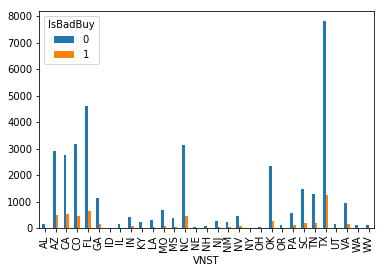

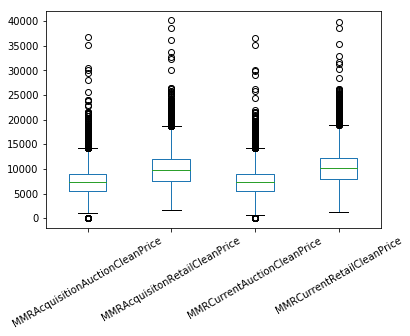

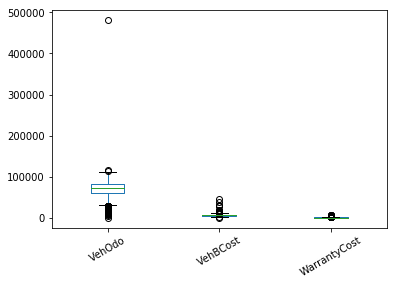

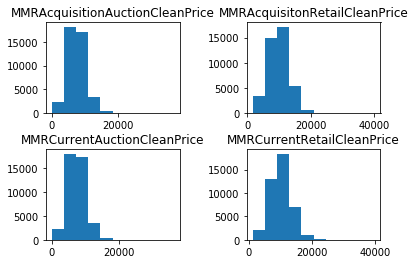

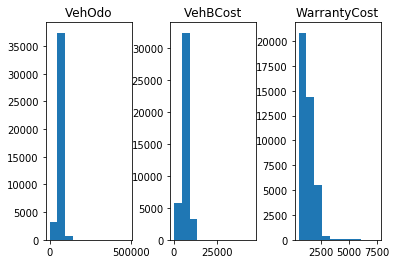

Lines Removed:  187


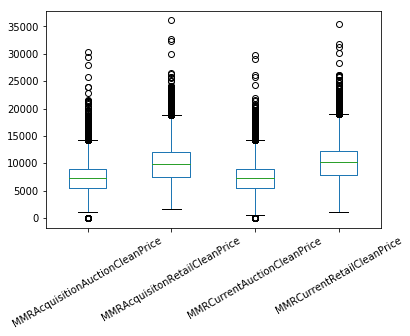

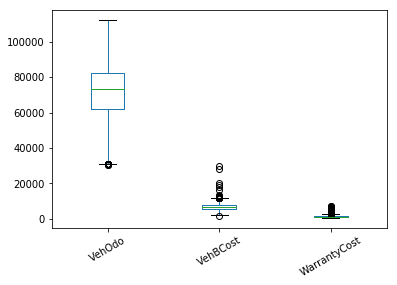

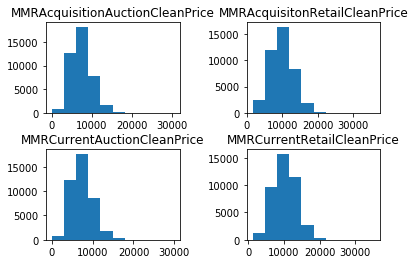

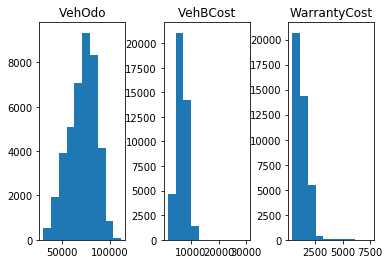

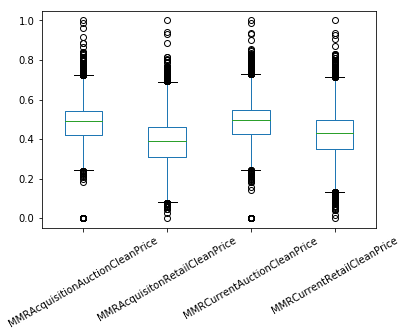

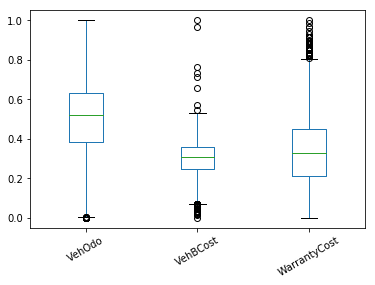

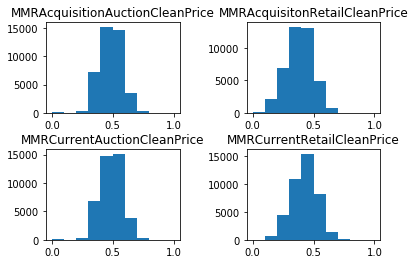

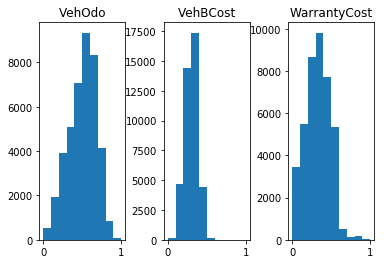

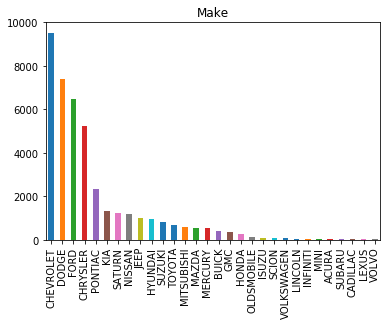

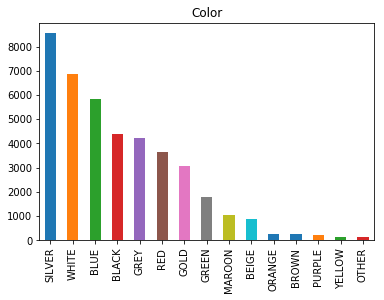

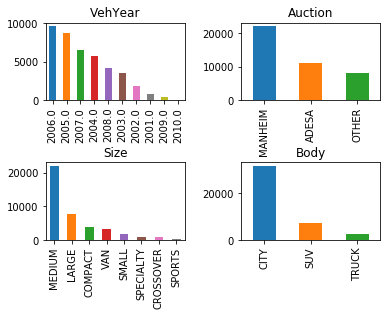

The number of features before one hot encoding is 20
The number of features after one hot encoding is 94
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41289 entries, 0 to 41475
Data columns (total 20 columns):
Auction                            41289 non-null object
VehYear                            41289 non-null float64
Make                               41289 non-null object
Color                              41289 non-null object
Auto                               41289 non-null float64
WheelType                          41289 non-null object
VehOdo                             41289 non-null float64
Nationality                        41289 non-null object
Size                               41289 non-null object
TopThreeAmericanName               41289 non-null object
MMRAcquisitionAuctionCleanPrice    41289 non-null float64
MMRAcquisitonRetailCleanPrice      41289 non-null float64
MMRCurrentAuctionCleanPrice        41289 non-null float64
MMRCurrentRetailCleanPrice         4128

In [172]:
data_raw = pd.read_csv("Kick.csv", # Read the csv into a DF
                   index_col = 'PurchaseID', 
                   na_values = ('?',  '#VALUE!'))

data, data_OH = PreProcessing(data_raw) # PreProcess the data

counts = data["IsBadBuy"].value_counts()
total = data["IsBadBuy"].count()
    
# calculate the percentage
# kick is where IsBadBuy == 1
kickPersentage = counts[1] / total * 100
print ("Questin 1.1 :")
print( kickPersentage, "%")

# target/input split
y = data_OH['IsBadBuy']
X = data_OH.drop(['IsBadBuy'], axis=1)

X_mat = X.values # Convert X into a matrix
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)

# Do the resampling
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

feature_names = X.columns

<h1>Task 1: Decision Trees</h1>

<h2>Task 1.1</h2>
<h3>What is the proportion of kicks?</h3>
The proportion of cars that are kick is 12.949...%

<h2>Task 1.2</h2>
<h3>Data fixes</h3>
* Treat '?' and '#VALUE' as NaN
* PRIMEUNIT and AUCGUART were dropped due to only having a small amount of data
* WheelTypeID and PurchaseDate were duplicates of other features and were dropped
* ForSale was dropped because of the data skew
* In TopThreeAmericanName Hyundai and Jeep were renamed into HYUNDAI and JEEP
* All other cols had there strings converted to uppercase
* In nationality USA was replaced to AMERICA
* Transmission was renamed to Auto and Auto was set to 1, Manual set to 0
* In Color, NOT AVIL was changed to NaN
* Dropped VNST due to statistical insignificance
* Size was split in to Size and Body and Van was placed into the Body feature
* Any non-zero values in IsOnlineSale was set to 1
* Changed PurchaseTimestamp into quarter
* Replace any missing values not specifically taken care of previously to a value chosen randomly from the distribution of the column
* Made one hot representaions of the categorical variables.
* Imputed mean of any numerical variables and normalized
 
<h2>Task 1.3</h2>
<h3>Patterns in the data</h3>
In the histograms and the Box plots we can clearly see that there are many outliers as well as skewed data values. The outliers are most likely due to the skewness. 

Both Fig. 1 and Fig. 2 shows in order lef-to-right, then top-to-bottom for the columns: ‘1. Acquisition Auction Price’, ‘2. Acquisition Retail Price’, ‘3. Current Auction Price’ and ‘.4 Current Retail Price’.
<figure>
    <img src="preOutlierBox.png" width="400">
    <figcaption> Fig. 1 Before removing outliers
</figure>
    
<figure>
    <img src="preOutlierHist.png" width="400">
    <figcaption> Fig. 2 Before removing outliers
</figure>
It was decided that outliers will be removed first then a re-evaluation will be done. These are the results:
<figure>
    <img src="postOutlierBox.png" width="400">
    <figcaption> Fig. 3 After removing outliers
</figure>
    
<figure>
    <img src="postOutlierHist.png" width="400">
    <figcaption> Fig. 4 After removing outliers
</figure>
As seen above the distribution is a lot better for : ‘3. Current Auction Price’ and ‘.4 Current Retail Price’. However, some skewness still exist in : ‘1. Acquisition Auction Price’,  and  ‘3. Current Auction Price’. The figure belows shows the fixed values
    
<figure>
    <img src="SkewFixed_Pricing.png" width="400">
    <figcaption> Fig. 5 After fixing the skew
</figure>

The next three graphs show the same transformations on different variables
<figure>
    <img src="triple1.png" width="400">
    <figcaption> Fig. 6 Before removing outlier
</figure>
<figure>
    <img src="triple2.png" width="400">
    <figcaption> Fig. 7 After removing outliers
</figure>
<figure>
    <img src="triple3.png" width="400">
    <figcaption> Fig. 8 After fixing the skew"
</figure>
    
Figure 9 shows Chevrolet, Dodge, Ford and Chrysler make the majority of cars on sale.

<figure>
    <img src="makeHist.png" width="400">
    <figcaption> Fig. 9 Histagrams of the makes
</figure>

Figure 10 shows most cars are a medium size and a city car.

<figure>
    <img src="othersHist.png" width="400">
    <figcaption> Fig. 10 Histagrams of the Sizes
</figure>
    
<h2>Task 1.4</h2>
<h3>What variables were included?</h3>
We used all features not dropped above.

| Variable Name           	| Role    	| Measurement Level 	|
|-------------------------	|---------	|-------------------	|
| Auction                 	| object  	| Nominal           	|
| VehYear                 	| float64 	| Interval          	|
| Make                    	| object  	| Nominal           	|
| Color	                   	| object  	| Nominal           	|
| Auto                    	| float64 	| Nominal           	|
| WheelType               	| object  	| Nominal           	|
| VehOdo                  	| float64 	| Ratio             	|
| Nationality             	| object  	| Nominal           	|
| Size                    	| object  	| Ordinal           	|
| TopThreeAmericanName    	| object  	| Nominal           	|
| MMRCurrentRetailRatio   	| float64 	| Interval          	|
| VehBCost                	| float64 	| Interval          	|
| IsOnlineSale            	| float64 	| Binary            	|
| WarrantyCost            	| float64 	| Interval          	|
| Body                    	| object  	| Nominal           	|
| Quarter                 	| int64   	| Ordinal           	|
| AcquisitionAuctionprice 	| float64 	| Interval          	|
| AcquisitionRetailPrice  	| float64 	| Interval          	|
| MMRCurrentAuctionPrice  	| float64 	| Interval          	|
| MMRCurrentRetailPrice   	| float64 	| Interval          	|


| Variable Name           	| Role    	| Measurement Level 	|
|-------------------------	|---------	|-------------------	|
| IsBadBuy                 	| Label  	| Boolean           	|
    
<h2>Task 1.5</h2>
<h3>What distibution scheme?</h3>
Used a train test split with a 20% test set. Using cross validation to train hyperparameters allows us to have a larger training set.

We tested the model on the data as is, oversampling and understampling. It was decided oversampled was the best as it gave us an even amount of positive and negative labels, the better accuracy as well as a better F1 score compared to the others . 

<h1>Task 2: Decision Trees</h1>

In [173]:
# simple decision tree training
DecisionTreeModel = DecisionTreeClassifier(random_state=rs)
DecisionTreeModel.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

<h2>Task 2.1</h2>
<h3>A: What is the test accuracy?</h3>    

In [174]:
print("Test Model Accuracy:", DecisionTreeModel.score(X_test, y_test))
print("Train Model Accuracy:", DecisionTreeModel.score(X_train, y_train))

Test Model Accuracy: 0.7839670622426738
Train Model Accuracy: 1.0


In [175]:
# Used through out 2.1
[n_nodes, leaf_count, main_variables] = getTreeInfo(DecisionTreeModel, feature_names) # Call the root function

<h3>B: What is the size of the tree?</h3>  

In [176]:
print("Number of Nodes:", n_nodes)

Number of Nodes: 9437


<h3>C: How many leaves are in the tree that is selected based on the validation data set?</h3>  

In [177]:
print("Number of leaves:", leaf_count)

Number of leaves: 4719


<h3>D: Which variable is used for the first split? What are the competing splits for this first split? </h3> 

In [178]:
print(main_variables)

Root feature is MMRCurrentAuctionCleanPrice
Competing featues are VehBCostand VehOdo


<h3>E: What are the 5 important variables in building the tree?</h3> 

In [179]:
analyse_feature_importance(DecisionTreeModel, feature_names, n_to_display=5)

VehBCost : 0.11042077206095711
MMRCurrentAuctionCleanPrice : 0.11009466719282167
VehOdo : 0.09924976952513076
MMRCurrentRetailRatio : 0.09688335836095614
MMRAcquisitionAuctionCleanPrice : 0.08905355519053461


<h3>F: Report if you see any evidence of model overfitting</h3> 

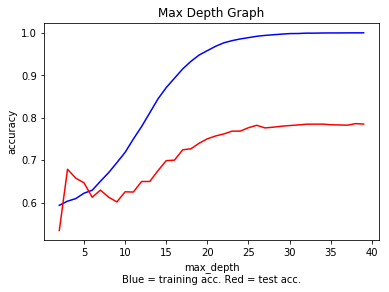

In [180]:
test_score = []
train_score = []

currRange = range(2 , DecisionTreeModel.tree_.max_depth)
# check the model performance for max depth from 2-20
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<p>As seen from the graph above, the training accuracy is 100% where as the test accuracy is nearing 80% - this is an idication of overfitting.</p>

<h3>G: Did changing the default setting help improving the model?</h3> 

In [181]:
splits = math.floor(max_depth/4) # half the number of nodes
model = DecisionTreeClassifier(min_samples_split=10)
model.fit(X_train, y_train)
max_depth = model.tree_.max_depth
splits = math.floor(max_depth/4) # half the number of nodes

<h4>Accuracy</h4>

In [182]:
print("Test Model Accuracy:", model.score(X_test, y_test))
print("Train Model Accuracy:", model.score(X_train, y_train))

# used throughout
[n_nodes, leaf_count, main_variables] = getTreeInfo(model, feature_names) # Call the root function

Test Model Accuracy: 0.7804553160571567
Train Model Accuracy: 0.9901053803081418


<h4> Size of the trees</h4>

In [183]:
# Size of the trees
print("Number of Nodes:", n_nodes)

Number of Nodes: 8725


<h4>Number of leaves</h4>

In [184]:
# Number of leaves
print("Number of leaves:", leaf_count)

Number of leaves: 4363


<h4>Important Splits</h4>

In [185]:
# First Split
print(main_variables)

Root feature is MMRCurrentAuctionCleanPrice
Competing featues are VehBCostand VehOdo


<h4>5 Most important</h4>

In [186]:
# 5 Most important
analyse_feature_importance(model, feature_names, n_to_display=5)

MMRCurrentAuctionCleanPrice : 0.11036910953785575
VehBCost : 0.11026971828665172
MMRCurrentRetailRatio : 0.09831383406650544
VehOdo : 0.09825219876830257
MMRAcquisitionAuctionCleanPrice : 0.0922814740492002


<h4>Sign of overfitting</h4>

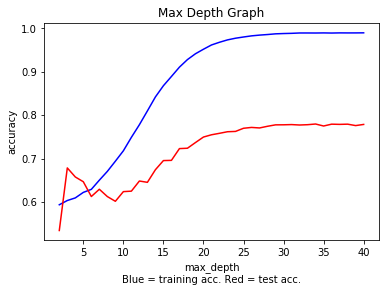

In [187]:
test_score = []
train_score = []

currRange = range(2 , model.tree_.max_depth)
# check the model performance for max depth from 2-20
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs, min_samples_split=splits)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<p>As seen from the graph above, the training accuracy is 100% where as the test accuracy is nearing 80% - this is an idication of overfitting.</p>

<h2>Task 2.2</h2>

In [188]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(2, 7), 'min_samples_leaf': range(20, 60, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [189]:
# Save the best features
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_DT = selectmodel.transform(X_train)
X_test_sel_DT = selectmodel.transform(X_test)

<h3>A: What is the classification accuracy on training and test datasets? </h3>   

In [190]:
print("Test Accuracy:", cv.score(X_test, y_test))
print("Train Accuracy:", cv.score(X_train, y_train))

Test Accuracy: 0.6151610559457495
Train Accuracy: 0.6280562028310089


In [191]:
# Used throught out 2.2
[n_nodes, leaf_count, main_variables] = getTreeInfo(cv.best_estimator_, feature_names) # Call the root function

<h3>B: What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?</h3>

In [192]:
print("Number of Nodes:", n_nodes)

Number of Nodes: 113


<p>Yes, due to it being optimised on the best pramaters and we limit the maximum depth.</p>

<h3>C: How many leaves are in the tree that is selected based on the validation data set?</h3>  

In [193]:
print("Number of leaves:", leaf_count)

Number of leaves: 57


<h3>D: Which variable is used for the first split? What are the competing splits for this first split? </h3>  

In [194]:
print(main_variables)

Root feature is MMRCurrentAuctionCleanPrice
Competing featues are VehBCostand VehOdo


<h3>E: What are the 5 important variables in building the tree?</h3>

In [195]:
analyse_feature_importance(cv.best_estimator_, feature_names, n_to_display=5)

MMRCurrentAuctionCleanPrice : 0.32498079449996603
VehBCost : 0.11542796629424604
MMRAcquisitionAuctionCleanPrice : 0.08566704222194947
Body_CITY : 0.08293788795988614
WheelType_COVERS : 0.06553106516472498


<h3>F: Report if you see any evidence of model overfitting</h3> 

In [196]:
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv.best_params_)

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      7188
           1       0.18      0.58      0.28      1070

   micro avg       0.62      0.62      0.62      8258
   macro avg       0.55      0.60      0.51      8258
weighted avg       0.81      0.62      0.68      8258

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 40}


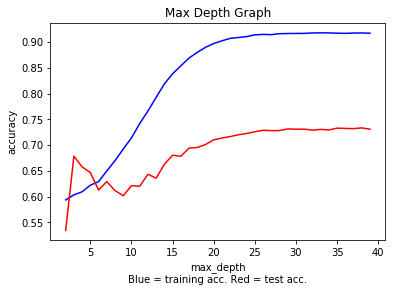

In [197]:
test_score = []
train_score = []

currRange = range(2 , 40)

# check the model performance for max depth from 2-30
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs, min_samples_split=cv.best_params_["min_samples_leaf"])
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<p>As seen in Task 2.2 A - the graph above shows a clear sign of overfitting as the test data is significant'y below the training data.

<h3>G: What are the parameters used? Justify your choices</h3> 

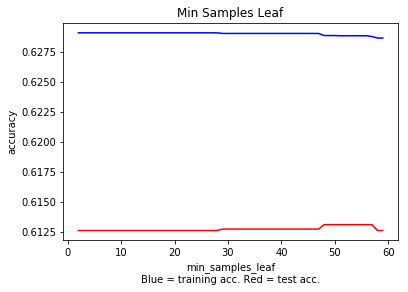

In [198]:
test_score = []
train_score = []

currRange = range(2 , 60)

# check the model performance for max depth from 2-20
for max_leaf in currRange:
    model = DecisionTreeClassifier(max_depth=6, random_state=rs, min_samples_split=max_leaf)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('min_samples_leaf\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Min Samples Leaf')
plt.show()

<p> There are three main choices used for the model: </p>
<p><b>Criterion:</b> gini</p> 
<p><b>max_depth:</b> 25 - we ran the max_depth from the minimum 2 to 40 and found after 6 we are getting deminishing returns, thus 25 was the optimal value (see graph in question F)</p> 
<p><b>min_samples_leaf:</b> 2 - we ran the min_sameples_leaf from the minimum 2 to 60 and found after 47 we are getting deminishing returns, thus 47 was the optimal value (see graph above)</p>

<h2>Task 2.3</h2>
<h4>What is the significant difference do you see between these two decision tree
models (steps 2.1 & 2.2)? How do they compare performance-wise? Explain why
those changes may have happened.</h4>

There are two main differences to concider between the model in 2.1 and 2.2.

<b>Performance</b><br>
Due to the Node size in 2.1 (9000 < nodes), the model performance is much lower than that of 2.2 (120 > nodes). Meaning when running the, 2.2 finds a solution much faster than 2.1

<b>Accuracy</b><br>
Due to the size of the tree in 2.1, one would assume that the accuracy is much higher, however, this is only true for the TRAIN data. Due to the size of the model, overfitting occurs and reduces the accuracy of the model on the TEST data.

The model in 2.2 is much smaller and one would except lower accuracy, but due to the model being well generalized it actually outperforms the overfitted model in 2.1.


<h2>Task 2.4</h2>
<h4>From the better model, can you identify which cars could potential be “kicks”?
Can you provide some descriptive summary of those cars?</h4>

<p>Yes we can predict which cars are kicks and describe the features that are most relevant to the prediction</p>
<b>Accuracy:</b>

In [199]:
De = DecisionTreeClassifier(min_samples_split=2, max_depth = 22)
De.fit(X_train, y_train)

print("Test Model Accuracy:", De.score(X_test, y_test))

Test Model Accuracy: 0.7628965851295714


<p>To get rules out of each attribute we will compare the mean of the kicks and non-kicks to the global mean of all the data. Should a clear pattern no emerge we will do further investigation</p>


<h3>MMRCurrentAuctionCleanPrice</h3>

count     5371.000000
mean      6709.345284
std       2864.711727
min          1.000000
25%       4585.000000
50%       6252.000000
75%       8305.000000
max      36478.000000
Name: MMRCurrentAuctionCleanPrice, dtype: float64

Kicks mean:  6709.345284139646
Non-Kicks mean:  7546.775017579977


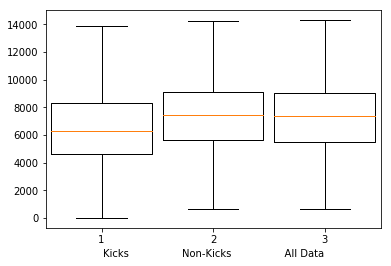

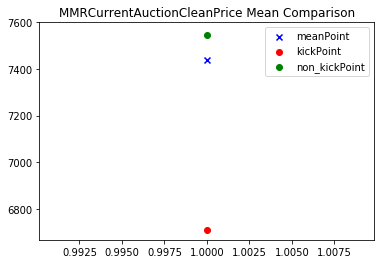

In [200]:
colors = ['b', 'r', 'g']

col_name = "MMRCurrentAuctionCleanPrice"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

<i>Description</i>
<p>As seen above, kicks for the MMRCurrentAuction attribute price differs from the non-kicks by having a mean (6709.34) that is lower than the mean for the non-kicks (7546.77) </p>
<p>As a rule of thumb - the <b>lower</b> the MMRCurrentAuction, the more likely it is to be a kick</p>

---------------------
count      5371.000000
mean      74328.853856
std       14259.635526
min        4825.000000
25%       65226.500000
50%       76390.000000
75%       84687.500000
max      115717.000000
Name: VehOdo, dtype: float64

Kicks mean:  74328.85385636946
Non-Kicks mean:  70849.43798355399


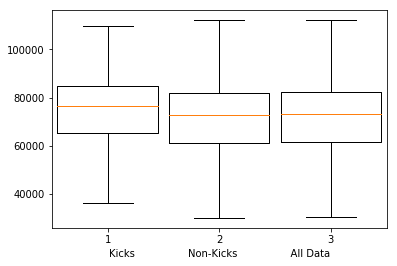

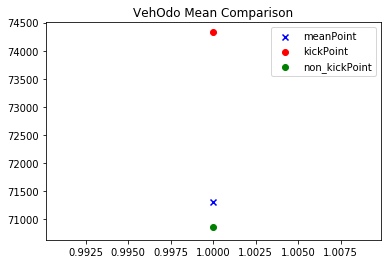

In [201]:
print("---------------------")
col_name = "VehOdo"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

<p>As seen above, kicks for the VehOdo attribute price differs from the non-kicks by having a mean (74328.85) that is higher than the mean for the non-kicks (70849.43) </p>
<p>As a rule of thumb - the <b>higher</b> the VehOdo, the more likely it is to be a kick</p>

count    5371.000000
mean        0.844177
std         0.053817
min         0.358071
25%         0.811476
50%         0.849511
75%         0.881650
max         0.982550
Name: MMRCurrentRetailRatio, dtype: float64

Kicks mean:  0.8441765533803434
Non-Kicks mean:  0.8588678360941439


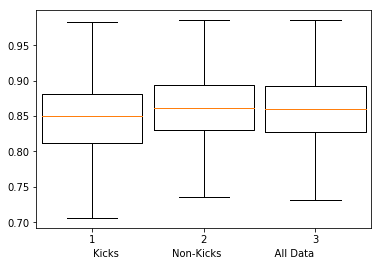

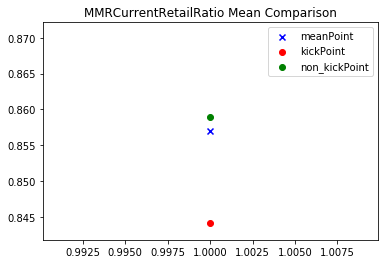

In [202]:
col_name = "MMRCurrentRetailRatio"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

<p>As seen above, kicks for the MMRCurrentRetailRatio attribute price differs from the non-kicks by having a mean (0.8441) that is higher than the mean for the non-kicks (0.8588) </p>
<p>As a rule of thumb - the <b>lower</b> the MMRCurrentRetailRatio, the more likely it is to be a kick</p>

count     5371.000000
mean      6256.526621
std       2101.210580
min        225.000000
25%       4745.000000
50%       5990.000000
75%       7532.500000
max      45469.000000
Name: VehBCost, dtype: float64

Kicks mean:  6256.526620914421
Non-Kicks mean:  6804.004359322234


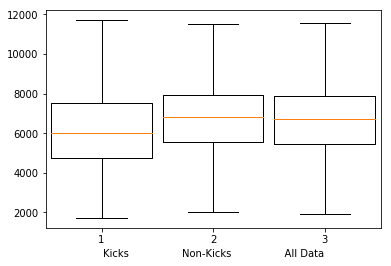

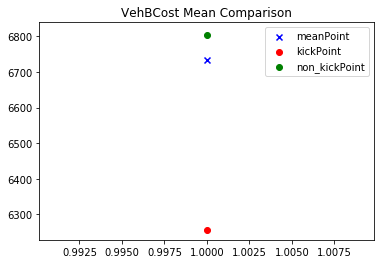

In [203]:
col_name = "VehBCost"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

<p>As seen above, kicks for the VehBCost attribute price differs from the non-kicks, by having a mean (6256.52) that is higher than the mean for the non-kicks (6804.00) </p>
<p>As a rule of thumb - the lower the VehBCost, the more likely it is to be a kick<p>

count     5371.000000
mean      6719.703425
std       2899.705472
min          1.000000
25%       4568.500000
50%       6298.000000
75%       8289.500000
max      36701.000000
Name: MMRAcquisitionAuctionCleanPrice, dtype: float64

Kicks mean:  6719.7034249348635
Non-Kicks mean:  7558.363167373504


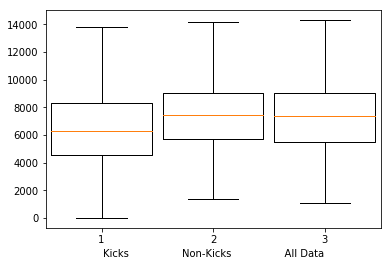

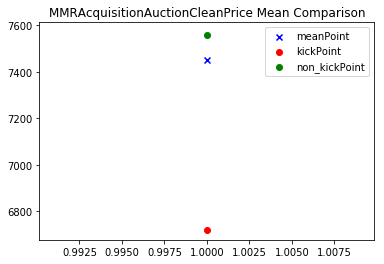

In [204]:
col_name = "MMRAcquisitionAuctionCleanPrice"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()

<p>As seen above, kicks for the VehBCost attribute price differs from the non-kicks, by having a mean (6256.52) that is higher than the mean for the non-kicks (6804.00) </p>
<p>As a rule of thumb - the lower the VehBCost, the more likely it is to be a kick<p>

<h2>Task 3.1</h2>

<p>Yes there were values that needed to be Imputed. These Columns where:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRAcquisitionAuctionAveragePrice <br>
MMRAcquisitionAuctionCleanPrice<br>
MMRAcquisitionRetailAveragePrice<br>
MMRAcquisitonRetailCleanPrice<br>
MMRCurrentAuctionAveragePrice<br>
MMRCurrentAuctionCleanPrice<br>
MMRCurrentRetailAveragePrice<br>
MMRCurrentRetailCleanPrice<br>
MMRCurrentRetailRatio<br>
<br>
VehOdo<br>
VehBCost<br>
WarrantyCost<br>
Color<br>
Auction<br>
VehYear<br>
Make<br>
Auto<br>
WheelType<br>
Nationality<br>
Size<br>
TopThreeAmericanName<br>
</div>


<h2>Task 3.2</h2>
<p>
There were four main transformations done.<br><br>

<b>Removing Outliers</b><br>
<p>After creating histograms and box plots it was noted that there is severe skew. The first step taken to remove the skew was to remove outliers for all varaibles. These columns were:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRAcquisitionAuctionCleanPrice<br>
MMRAcquisitonRetailCleanPrice<br>
MMRCurrentAuctionCleanPrice<br>
MMRCurrentRetailCleanPrice<br>
VehOdo<br>
</div>

<b>Sqaure Root Transformations</b><br>
After the initial removal of outliers, more box plots and histograms were created. From this it was noted that the "Auction" variables still had some skew. To fix this these were transformed using the Sqaur Root of the varaible on the Price variables.
<p>Yes there were values that needed to be Imputed. These Columns where:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
MMRCurrentAuctionCleanPrice<br>
MMRCurrentRetailCleanPrice<br>
MMRAcquisitionAuctionCleanPrice<br>
MMRAcquisitonRetailCleanPrice<br>
VehOdo<br>
</div>

<b>Log Transformations</b><br>
<p>some of the varaibles were found to be better suited to a Log transformation. These variables were:</p>
<div style='background: #f4f4f4; border: 1px solid #ddd;border-left: 3px solid #f36d33; color: #665; page-break-inside: avoid;    font-family: monospace;font-size: 15px; line-height: 1.6; margin-bottom: 1.6em;
    max-width: 100%;
    overflow: auto;
    padding: 1em 1.5em;
    display: block;
    word-wrap: break-word;'>
VehOdo<br>
WarrantyCost<br>
</div>

<b>Normilising Values</b><br>
All the numerical variables were then normalized for consistency.






<h2>Task 3.3</h2>


In [205]:
# initialise a standard scaler object
model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)
model2 = cv.best_estimator_

<h3>H: Name the regression function used</h3>

<p>LogisticRegression, from the sklearn library</p>

<h3>I: How much was the difference in performance of two models build, default
and optimal?</h3>

<p><b>Standard Model</b></p>

In [206]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.91      0.63      0.75      7188
           1       0.20      0.60      0.30      1070

   micro avg       0.63      0.63      0.63      8258
   macro avg       0.56      0.62      0.52      8258
weighted avg       0.82      0.63      0.69      8258

Train accuracy: 0.6297255938510764
Test accuracy: 0.6295713247759748


<p><b>Optimised Model</b></p>

In [207]:
y_pred = model2.predict(X_test)
print(classification_report(y_test, y_pred))
print("Train accuracy:", model2.score(X_train, y_train))
print("Test accuracy:", model2.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.92      0.64      0.75      7188
           1       0.20      0.61      0.30      1070

   micro avg       0.63      0.63      0.63      8258
   macro avg       0.56      0.62      0.52      8258
weighted avg       0.82      0.63      0.69      8258

Train accuracy: 0.6309602476263346
Test accuracy: 0.6321143133930733


<p> Both the test and train accuracy for both models were very similar at roughly 63%</p>

<h3>J: Show the set parameters for the best model. What are the parameters used?
Explain your decision. What are the optimal parameters?</h3>

In [208]:
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

              precision    recall  f1-score   support

           0       0.92      0.64      0.75      7188
           1       0.20      0.61      0.30      1070

   micro avg       0.63      0.63      0.63      8258
   macro avg       0.56      0.62      0.52      8258
weighted avg       0.82      0.63      0.69      8258

{'C': 1000}


We changed the C value to try and intoduce a l2 regularizing factor to regreduce overfitting. We did not change the solver because the default solver (liblinear) is a great solver for small data sets and supports l2 regularizing. 

<h3>K: Report which variables are included in the regression model.</h3>

In [209]:
# grab feature importances from the model and feature name from the original X
coef = model2.coef_[0]

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 5 features, you can leave this out to print out everything
num_features = 5
indices = indices[:num_features]

for i in indices:
    print(feature_names[i], ':', coef[i])

Make_VOLVO : -11.02950900810058
MMRAcquisitonRetailCleanPrice : 7.154264685735614
MMRAcquisitionAuctionCleanPrice : -5.328262386461647
MMRCurrentRetailCleanPrice : -4.946703225908925
Make_VOLKSWAGEN : -4.929913710764012


We included all that weren't dropped initially - see prerpocessing step

<h3>L: Report the top-5 important variables (in the order) in the model.</h3>

In [210]:
# grab feature importances from the model and feature name from the original X
coef = model2.coef_[0]

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 5 features, you can leave this out to print out everything
num_features = 5
indices = indices[:num_features]

for i in indices:
    print(feature_names[i], ':', coef[i])

Make_VOLVO : -11.02950900810058
MMRAcquisitonRetailCleanPrice : 7.154264685735614
MMRAcquisitionAuctionCleanPrice : -5.328262386461647
MMRCurrentRetailCleanPrice : -4.946703225908925
Make_VOLKSWAGEN : -4.929913710764012


<h3>M: What is classification accuracy on training and test datasets?</h3>

In [211]:
print("Accuracy for the best performing model on test and train")
print("Train accuracy:", model2.score(X_train, y_train))
print("Test accuracy:", model2.score(X_test, y_test))

Accuracy for the best performing model on test and train
Train accuracy: 0.6309602476263346
Test accuracy: 0.6321143133930733


<h3>N: Report any sign of overfitting</h3>

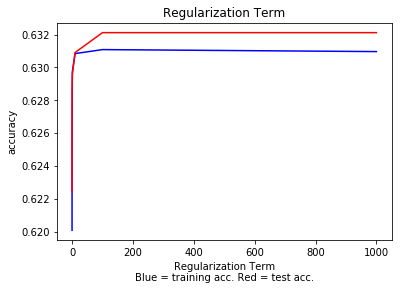

In [212]:
test_score = []
train_score = []

range_ = [pow(10, x) for x in range(-2, 4)]

for i in range_:
    model = LogisticRegression(random_state=rs, C=i)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Regularization Term\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Regularization Term')
plt.show()

We do not have overfitting, this model is under fitting

<h2>Task 3.4</h2>

In [213]:
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

<h3>A: Report which variables are included in the regression model</h3>

In [214]:
# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

print("The columns selected by rfe is/are ")
for i in range(1, len(list(X.columns[rfe.get_support(indices=True)]))):
    print(list(X.columns[rfe.get_support(indices=True)])[i])

Original feature set 93
Number of features after elimination 56
The columns selected by rfe is/are 
VehOdo
MMRAcquisitionAuctionCleanPrice
MMRAcquisitonRetailCleanPrice
MMRCurrentAuctionCleanPrice
MMRCurrentRetailCleanPrice
MMRCurrentRetailRatio
VehBCost
Auction_ADESA
Auction_OTHER
Make_ACURA
Make_BUICK
Make_CADILLAC
Make_CHEVROLET
Make_CHRYSLER
Make_DODGE
Make_FORD
Make_HONDA
Make_HYUNDAI
Make_INFINITI
Make_ISUZU
Make_JEEP
Make_KIA
Make_LEXUS
Make_MAZDA
Make_MERCURY
Make_MINI
Make_MITSUBISHI
Make_NISSAN
Make_OLDSMOBILE
Make_PONTIAC
Make_SATURN
Make_SCION
Make_TOYOTA
Make_VOLVO
Color_BROWN
Color_OTHER
Color_PURPLE
VehYear_2001.0
VehYear_2002.0
VehYear_2003.0
VehYear_2004.0
VehYear_2006.0
VehYear_2007.0
VehYear_2008.0
VehYear_2009.0
VehYear_2010.0
Nationality_TOP LINE ASIAN
Size_COMPACT
Size_SMALL
Size_SPORTS
Body_SUV
TopThreeAmericanName_CHRYSLER
TopThreeAmericanName_FORD
TopThreeAmericanName_GM
TopThreeAmericanName_OTHER


<h3>B: Report the top-5 important variables (in the order) in the model.</h3>

In [215]:
# Make another model to extract valueable info
# Get best params
params = {'C': [pow(10, x) for x in range(-4, 1)]}
cvRFE = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cvRFE.fit(X_train_sel, y_train)
print(cvRFE.best_params_)

# Get coefs
coefLG = cvRFE.best_estimator_.coef_[0]
# limit to 5 features, you can comment the following line to print out everything
coefLG = coefLG[:5]

for i in range(len(coefLG)):
    print(feature_names[i], ':', coefLG[i])

{'C': 1}
Auto : 0.43416617996601187
VehOdo : 0.48132037210804357
MMRAcquisitionAuctionCleanPrice : -3.5957564769715558
MMRAcquisitonRetailCleanPrice : 5.7057805984257
MMRCurrentAuctionCleanPrice : 3.061346650302958


<h3>C: What are the parameters are used and which are optimal?</h3>

RFECV only used one parameter, which was the logistic regression estimator. We then passed the best features to a gridsearch, finding a C value of 1 was best

<h3>D: Report any signs of overfitting.</h3>

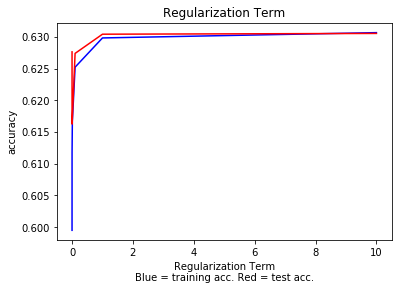

In [216]:
test_score = []
train_score = []

range_ = [pow(10, x) for x in range(-4, 2)]

for i in range_:
    model = LogisticRegression(random_state=rs, C=i)
    model.fit(X_train_sel, y_train)
    
    test_score.append(model.score(X_test_sel, y_test))
    train_score.append(model.score(X_train_sel, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Regularization Term\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Regularization Term')
plt.show()

The model is neither over or under fitting

<h3>E: What is classification accuracy on training and test datasets?</h3>

In [217]:
model = LogisticRegression(random_state=rs, C=1)
model.fit(X_train_sel, y_train)

print("Accuracy for the best performing model on test and train")
print("Train accuracy:", model.score(X_train_sel, y_train))
print("Test accuracy:", model.score(X_test_sel, y_test))

Accuracy for the best performing model on test and train
Train accuracy: 0.6298299307898306
Test accuracy: 0.630418987648341


<h3>F: Did it improve/worsen the performance?</h3>

The perfomance did not noticable change, with the improved accuracy still around the same as the previous at 63%.

<h2>Task 3.5</h2>

<h3>MMRCurrentAuctionPrice (Clean or Average)</h3>

count     5371.000000
mean      6709.345284
std       2864.711727
min          1.000000
25%       4585.000000
50%       6252.000000
75%       8305.000000
max      36478.000000
Name: MMRCurrentAuctionCleanPrice, dtype: float64

Kicks mean:  6709.345284139646
Non-Kicks mean:  7546.775017579977


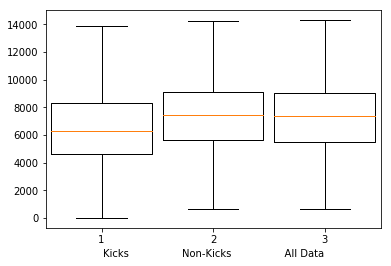

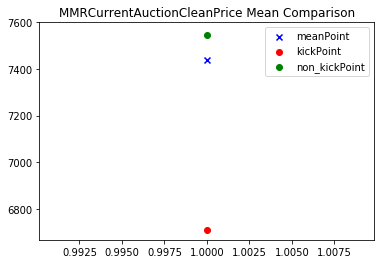

In [218]:
colors = ['b', 'r', 'g']

col_name = "MMRCurrentAuctionCleanPrice"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()


<i>Description</i>
<p>As seen above, kicks for the MMRCurrentAuction attribute price differs from the non-kicks by having a mean (6709.34) that is lower than the mean for the non-kicks (7546.77) </p>
<p>As a rule of thumb - the <b>lower</b> the MMRCurrentAuction, the more likely it is to be a kick</p>

<h3>VehOdo</h3>

count      5371.000000
mean      74328.853856
std       14259.635526
min        4825.000000
25%       65226.500000
50%       76390.000000
75%       84687.500000
max      115717.000000
Name: VehOdo, dtype: float64

Kicks mean:  74328.85385636946
Non-Kicks mean:  70849.43798355399


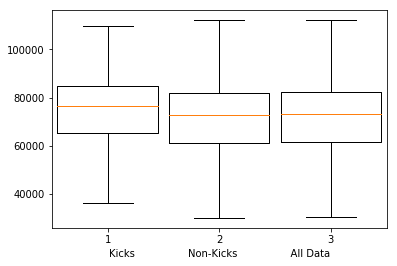

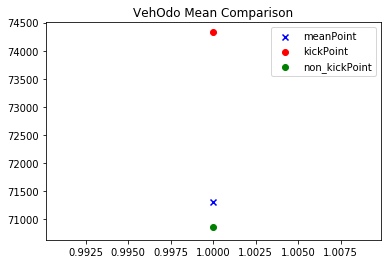

In [219]:
col_name = "VehOdo"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()


<p>As seen above, kicks for the VehOdo attribute price differs from the non-kicks by having a mean (74328.85) that is higher than the mean for the non-kicks (70849.43) </p>
<p>As a rule of thumb - the <b>higher</b> the VehOdo, the more likely it is to be a kick</p>

<h3>MMRCurrentRetailRatio</h3>

count    5371.000000
mean        0.844177
std         0.053817
min         0.358071
25%         0.811476
50%         0.849511
75%         0.881650
max         0.982550
Name: MMRCurrentRetailRatio, dtype: float64

Kicks mean:  0.8441765533803434
Non-Kicks mean:  0.8588678360941439


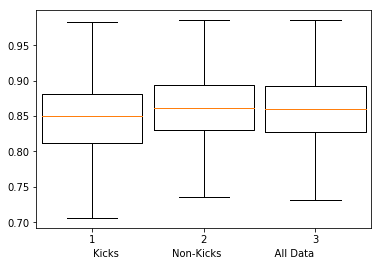

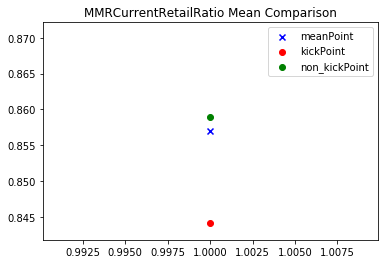

In [220]:
col_name = "MMRCurrentRetailRatio"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()


<p>As seen above, kicks for the MMRCurrentRetailRatio attribute price differs from the non-kicks by having a mean (0.8441) that is higher than the mean for the non-kicks (0.8588) </p>
<p>As a rule of thumb - the <b>lower</b> the MMRCurrentRetailRatio, the more likely it is to be a kick</p>

<h3>VehBCost</h3>

count     5371.000000
mean      6256.526621
std       2101.210580
min        225.000000
25%       4745.000000
50%       5990.000000
75%       7532.500000
max      45469.000000
Name: VehBCost, dtype: float64

Kicks mean:  6256.526620914421
Non-Kicks mean:  6804.004359322234


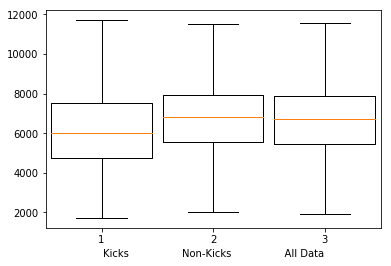

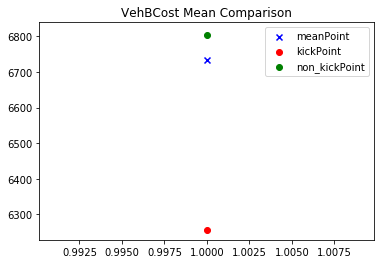

In [221]:
col_name = "VehBCost"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()


<p>As seen above, kicks for the VehBCost attribute price differs from the non-kicks, by having a mean (6256.52) that is higher than the mean for the non-kicks (6804.00) </p>
<p>As a rule of thumb - the lower the VehBCost, the more likely it is to be a kick<p>

<h3>MMRAcquisitionAuctionCleanPrice</h3>

count     5371.000000
mean      6719.703425
std       2899.705472
min          1.000000
25%       4568.500000
50%       6298.000000
75%       8289.500000
max      36701.000000
Name: MMRAcquisitionAuctionCleanPrice, dtype: float64

Kicks mean:  6719.7034249348635
Non-Kicks mean:  7558.363167373504


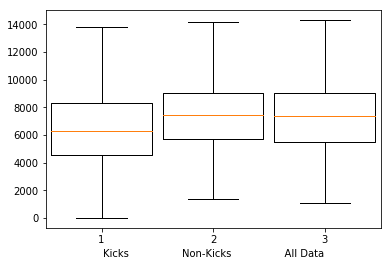

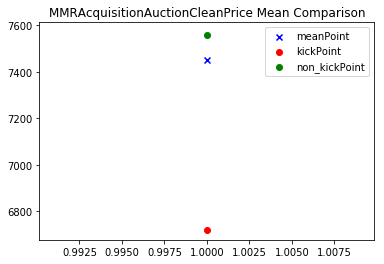

In [222]:
col_name = "MMRAcquisitionAuctionCleanPrice"
kicks = data_raw.loc[data_raw.IsBadBuy == 1, col_name]
non_kicks = data_raw.loc[data_raw.IsBadBuy == 0, col_name]
dat = data_raw[col_name]
mean_ = dat.describe()["mean"]

print(kicks.describe())
print("")
print("Kicks mean: ", kicks.mean())
print("Non-Kicks mean: ", non_kicks.mean())
fig = plt.figure()
bp = plt.boxplot([kicks, non_kicks, dat], showfliers=False, widths=0.9)
plt.xlabel("Kicks                 Non-Kicks                 All Data")
plt.show()

fig = plt.figure()

col_name += " Mean Comparison"
plt.title(col_name)
meanPoint  = plt.scatter(1, mean_, marker='x', color=colors[0])
kickPoint  = plt.scatter(1, kicks.mean(), marker='o', color=colors[1])
non_kickPoint  = plt.scatter(1, non_kicks.mean(), marker='o', color=colors[2])
plt.legend((meanPoint, kickPoint, non_kickPoint), ('meanPoint', 'kickPoint', 'non_kickPoint'))
plt.show()


<p>As seen above, kicks for the VehBCost attribute price differs from the non-kicks, by having a mean (6256.52) that is higher than the mean for the non-kicks (6804.00) </p>
<p>As a rule of thumb - the lower the VehBCost, the more likely it is to be a kick<p>

<h2>Task 4.1</h2>

In [223]:
model = MLPClassifier(random_state=rs) # Define the model
model.fit(X_train, y_train) # Fit it
y_pred = model.predict(X_test)

<h3>A: What is the network architecture?</h3>

In [224]:
print("The neural network has ", model.n_layers_, " layers")
print("and ", model.hidden_layer_sizes[0], " nodes per layer")

The neural network has  3  layers
and  100  nodes per layer


<h3>B: How many iterations are needed to train this network?</h3>

In [225]:
print("The model has ran through ", model.n_iter_, " iterations")

The model has ran through  200  iterations


<h3>C: Do you see any sign of over-fitting?</h3>

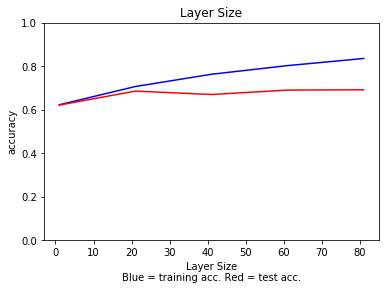

In [226]:
test_score = []
train_score = []

range_ = range(1, 100, 20)

for i in range_:
    model = MLPClassifier(hidden_layer_sizes = i, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Layer Size\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Layer Size')
plt.show()

There is a small amount of overfitting, the training accuracy is just above the test accuracy. 

<h3>D: Did the training process converge and resulted in the best model?</h3>

No, as seen in graph above, the model starts to converge, but then diverges. 

<h3>E: What is classification accuracy on training and test datasets?</h3>

In [227]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Train accuracy: 0.8356519319723159
Test accuracy: 0.6918139985468637
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      7188
           1       0.18      0.41      0.25      1070

   micro avg       0.68      0.68      0.68      8258
   macro avg       0.53      0.56      0.52      8258
weighted avg       0.80      0.68      0.72      8258



<h2>Task 4.2</h2>

In [228]:
# Use GCV and change the no. of hidden nodes
params = {'hidden_layer_sizes': [(x,) for x in range(2, 7)], 'alpha': [pow(10, x) for x in range(-6, 2)]}
cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

<h3>A: What is the network architecture?</h3>

In [229]:
print("The neural network has ", cv.best_estimator_.n_layers_, " layers")
print("and ", cv.best_estimator_.hidden_layer_sizes[0], " nodes per layer")
print("and ", cv.best_estimator_.alpha, " alpha")

The neural network has  3  layers
and  6  nodes per layer
and  1e-06  alpha


<h3>B: How many iterations are needed to train this network?</h3>

In [230]:
print("The model has ran through ", cv.best_estimator_.n_iter_, " iterations")

The model has ran through  147  iterations


<h3>C: Do you see any sign of over-fitting?</h3>

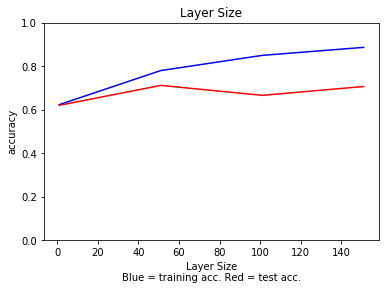

In [231]:
test_score = []
train_score = []

range_ = range(1, 200, 50)

for i in range_:
    model = MLPClassifier(hidden_layer_sizes=i, alpha=0.01, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Layer Size\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Layer Size')
plt.show()

The model is overfitting. The training accuracy is slightly higher than the testing.

<h3>D: Did the training process converge and resulted in the best model?</h3><br>
This model diverges, as seen in the figure above

<h3>E: What is classification accuracy on training and test datasets?</h3>

In [232]:
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Train accuracy: 0.6607832226202484
Test accuracy: 0.6162509082102204
              precision    recall  f1-score   support

           0       0.91      0.62      0.74      7188
           1       0.19      0.60      0.29      1070

   micro avg       0.62      0.62      0.62      8258
   macro avg       0.55      0.61      0.51      8258
weighted avg       0.82      0.62      0.68      8258



<h2>Task 4.3</h2>

<b>Decision Tree Features</b>

In [233]:
modelDT = MLPClassifier(hidden_layer_sizes = (6,), alpha = 0.01, random_state=rs) # Define the model
modelDT.fit(X_train_sel_DT, y_train) # Fit it
y_predDT = modelDT.predict(X_test_sel_DT)

<b>RFECV Features</b>

In [234]:
# MLP with rfe features
modelRFE = MLPClassifier(hidden_layer_sizes = (6,), alpha = 0.01, random_state=rs) # Define the model
modelRFE.fit(X_train_sel, y_train) # Fit it
y_predRFE = modelRFE.predict(X_test_sel)

<h3>A: What is the network architecture?</h3>

<b>Decision Tree Features</b>

In [235]:
print("The neural network has ", modelDT.n_layers_, " layers")
print("and ", modelDT.hidden_layer_sizes[0], " nodes per layer")

The neural network has  3  layers
and  6  nodes per layer


<b>RFECV Features</b>

In [236]:
print("The neural network has ", modelRFE.n_layers_, " layers")
print("and ", modelRFE.hidden_layer_sizes[0], " nodes per layer")

The neural network has  3  layers
and  6  nodes per layer


<h3>B: How many iterations are needed to train this network?</h3>

<b>Decision Tree Features</b>

In [237]:
print("The model has ran through ", modelDT.n_iter_, " iterations")

The model has ran through  94  iterations


<b>RFECV Features</b>

In [238]:
print("The model has ran through ", modelRFE.n_iter_, " iterations")

The model has ran through  112  iterations


<h3>C: Do you see any sign of over-fitting?</h3>

<b>Decision Tree Features</b>

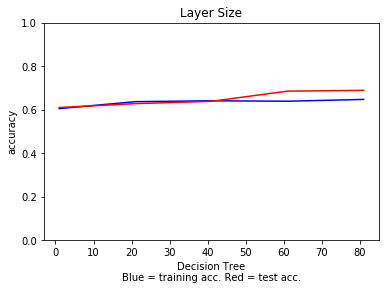

In [239]:
test_score = []
train_score = []

range_ = range(1, 100, 20)

for i in range_:
    model = MLPClassifier(hidden_layer_sizes=i, alpha=0.01, random_state=rs)
    model.fit(X_train_sel_DT, y_train)
    
    test_score.append(model.score(X_test_sel_DT, y_test))
    train_score.append(model.score(X_train_sel_DT, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('Decision Tree\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Layer Size')
plt.show()

This model is neither over fitting or underfitting. The training and test accuracy are running very close to each other

<b>RFECV Features</b>

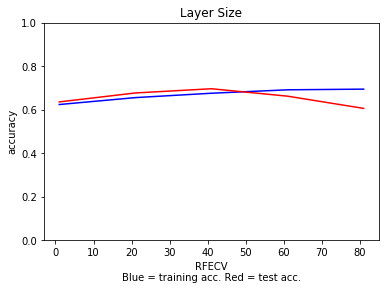

In [240]:
test_score = []
train_score = []

range_ = range(1, 100, 20)

for i in range_:
    model = MLPClassifier(hidden_layer_sizes=i, alpha=0.01, random_state=rs)
    model.fit(X_train_sel, y_train)
    
    test_score.append(model.score(X_test_sel, y_test))
    train_score.append(model.score(X_train_sel, y_train))

plt.plot(range_, train_score, 'b', range_, test_score, 'r')
plt.xlabel('RFECV\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Layer Size')
plt.show()

<h3>D: Did the training process converge and resulted in the best model?</h3>

<b>Decision Tree Features</b><br>
This model does seem to converge. The training and test data are very similar.

<b>RFECV Features</b><br>
This model seems to diverge

<h3>E: What is classification accuracy on training and test datasets?</h3>

<b>Decision Tree Features</b>

In [241]:
print("Using features selected from the decision tree, the train accuracy:", modelDT.score(X_train_sel_DT, y_train))
print("Using features selected from the decision tree, the test accuracy:", modelDT.score(X_test_sel_DT, y_test))
print(classification_report(y_test, y_predDT))

Using features selected from the decision tree, the train accuracy: 0.6228915243626753
Using features selected from the decision tree, the test accuracy: 0.5696294502300799
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      7188
           1       0.18      0.67      0.29      1070

   micro avg       0.57      0.57      0.57      8258
   macro avg       0.55      0.61      0.49      8258
weighted avg       0.82      0.57      0.64      8258



<b>RFECV Features</b>

In [242]:
print("Using features selected from the RFECV, the train accuracy:", modelRFE.score(X_train_sel, y_train))
print("Using features selected from the RFECV, the test accuracy:", modelRFE.score(X_test_sel, y_test))
print(classification_report(y_test, y_predRFE))

Using features selected from the RFECV, the train accuracy: 0.6400897297673286
Using features selected from the RFECV, the test accuracy: 0.6186728021312666
              precision    recall  f1-score   support

           0       0.91      0.62      0.74      7188
           1       0.19      0.61      0.29      1070

   micro avg       0.62      0.62      0.62      8258
   macro avg       0.55      0.61      0.52      8258
weighted avg       0.82      0.62      0.68      8258



In [243]:
# Extract top 5 important features
coefLG = modelRFE.coefs_[0]
# limit to 5 features, you can comment the following line to print out everything
coefLG = coefLG[:5]

for i in range(len(coefLG)):
    print(feature_names[i], ':', coefLG[i])

Auto : [ 0.18696694  0.01145332  0.12477641  0.60383926 -0.12542508 -0.13438245]
VehOdo : [-0.22305388  0.19628533 -0.07129757  0.34476894 -0.18471361  0.2950202 ]
MMRAcquisitionAuctionCleanPrice : [ 0.10397388 -0.00327252  0.53965458 -0.03139585  0.42545988 -0.14750372]
MMRAcquisitonRetailCleanPrice : [-0.94787261  0.40957227 -1.0627093   1.22784436 -0.99593474 -0.81307286]
MMRCurrentAuctionCleanPrice : [-0.13184741  0.13418751  0.0169821   0.36313447 -0.03084193  0.05000636]


<h2>Task 4.4</h2>

<b>All Data</b>

ROC index on test for DT: 0.537367705261625
ROC index on test for logistic regression: 0.6674850087633075
ROC index on test for NN: 0.6550339610669912


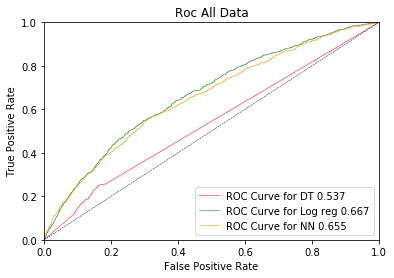

In [244]:
# Decision Tree
modelDT = DecisionTreeClassifier(max_depth = 22, min_samples_split = 2, random_state=rs) # Define the model
modelDT.fit(X_train, y_train) # Fit with data

# Neural network
modelMLP = MLPClassifier(hidden_layer_sizes = 6, alpha = 0.01, random_state=rs) # Define the model
modelMLP.fit(X_train, y_train) # Fit it

# Logisitc Regression
modelLG = LogisticRegression(C = 1, random_state=rs) # Define the model
modelLG.fit(X_train, y_train) # fit it to training data

# Compare the models

# ROC AUC
y_pred_proba_dt = modelDT.predict_proba(X_test)
y_pred_proba_log_reg = modelLG.predict_proba(X_test)
y_pred_proba_nn = modelMLP.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc All Data')
plt.legend(loc="lower right")
plt.show()

<b>Selected Data</b>

ROC index on test for DT: 0.558400163304365
ROC index on test for logistic regression: 0.6673477082780751
ROC index on test for NN: 0.6589184206283578


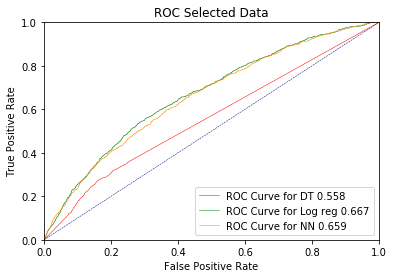

In [245]:
# Decision Tree
modelDT = DecisionTreeClassifier(max_depth = 22, min_samples_split = 2, random_state=rs) # Define the model
modelDT.fit(X_train_sel, y_train) # Fit with data
y_predDT = modelDT.predict(X_test_sel)

# Neural network
modelMLP = MLPClassifier(hidden_layer_sizes = 6, alpha = 0.01, random_state=rs) # Define the model
modelMLP.fit(X_train_sel, y_train) # Fit it
y_predMLP = modelMLP.predict(X_test_sel)

# Logisitc Regression
modelLG = LogisticRegression(C = 1, random_state=rs) # Define the model
modelLG.fit(X_train_sel, y_train) # fit it to training data
y_predLG = modelLG.predict(X_test_sel)

# Compare the models

# ROC AUC
y_pred_proba_dt = modelDT.predict_proba(X_test_sel)
y_pred_proba_log_reg = modelLG.predict_proba(X_test_sel)
y_pred_proba_nn = modelMLP.predict_proba(X_test_sel)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Selected Data')
plt.legend(loc="lower right")
plt.show()

<b>Which Model Is Better</b><br>
The two ROC graphs above show which model performes better on each data set. The logestic regression model is better both times, with nueral network only slightly worse<br>
<b>Which cars are kicks?</b><br>

<b>Comprehention</b><br>
Which nueral network is better is easy to understand, with graphs showing if a model is overfitting or underfitting, and single number scores a model can be evaluated very quickly. ROC scores and graphs make comparing models beteween each other easy. 

<h2>Task 5.1</h2>

In [246]:
# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=[('dt', modelDT), ('lr', modelLG), ('nn', modelMLP)], voting='soft')

# fit the voting classifier to training data
voting.fit(X_train_sel, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train_sel, y_train))
print("Ensemble test accuracy:", voting.score(X_test_sel, y_test))

Ensemble train accuracy: 0.9137655201196397
Ensemble test accuracy: 0.7553887139743279


<h3>A: Does the Ensemble model outperform the underlying models? Resonate
your answer.</h3>

<p>The ensamble model does outperform the rest. Overall the ensamble model has the best accuracy, general fit and output. see section 5.2 for more deailed answer and mathimatical explination.</p><br>

<h2>Task 5.1</h2>
<h3>Discuss the findings led by</h3> <br><b>(a) ROC Chart (and Index)</b>

ROC index on test for DT: 0.558400163304365
ROC index on test for logistic regression: 0.6673477082780751
ROC index on test for NN: 0.6589184206283578
ROC index on test for Ensemble: 0.6579335236817333


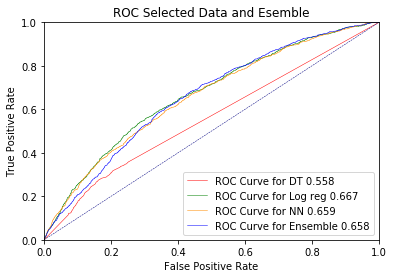

In [247]:
y_pred_proba_vote = voting.predict_proba(X_test_sel)
roc_index_vote = roc_auc_score(y_test, y_pred_proba_vote[:, 1])
fpr_vote, tpr_vote, thresholds_vote = roc_curve(y_test, y_pred_proba_vote[:,1])
y_predV = voting.predict(X_test_sel)

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)
plt.plot(fpr_vote, tpr_vote, label='ROC Curve for Ensemble {:.3f}'.format(roc_index_vote), color='blue', lw=0.5)

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)
print("ROC index on test for Ensemble:", roc_index_vote)

# plt.plot(fpr[2], tpr[2], color='darkorange',
# lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Selected Data and Esemble')
plt.legend(loc="lower right")
plt.show()

<i>Discussion:</i>
<p>From the ROC chart above as well as the Index we can see that the Ensemble model having an index of (0.659) is only slightly out performed by the Logistics model and the Nueral Network at an index of (0.667 and 0.663) respectively. it is clear that all three outperforms the Decision Tree drastically.</p>

<b>(b) Score Ranking (or Accuracy Score)</b>

In [248]:
print("The best decision tree had a test accuracy of:", modelDT.score(X_test_sel, y_test))
print("The best logistic regression had a test accuracy of:", modelLG.score(X_test_sel, y_test))
print("The best MLP had a test accuracy of:", modelMLP.score(X_test_sel, y_test))
print("The best ensemble had a test accuracy of:", voting.score(X_test_sel, y_test))

The best decision tree had a test accuracy of: 0.7371034148704286
The best logistic regression had a test accuracy of: 0.630418987648341
The best MLP had a test accuracy of: 0.6186728021312666
The best ensemble had a test accuracy of: 0.7553887139743279


<i>Discussion:</i>
<p>In the case of pure acceracy the Ensamble model does outperform the rest of the models, only matched by the decision tree. Both these models have an accuracy of (75%) </p>
<br><br>
<b>(c) Fit Statistics(or Classification report)</b>

In [249]:
print("The best decision tree had a test accuracy of:")
print(classification_report(y_test, y_predDT))
print("----------\n The best logistic regression had a test accuracy of:")
print(classification_report(y_test, y_predLG))
print("----------\n The best MLP had a test accuracy of:")
print(classification_report(y_test, y_predMLP))
print("----------\n The best ensemble had a test accuracy of:")
print(classification_report(y_test, y_predV))

The best decision tree had a test accuracy of:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      7188
           1       0.19      0.31      0.23      1070

   micro avg       0.74      0.74      0.74      8258
   macro avg       0.54      0.55      0.54      8258
weighted avg       0.80      0.74      0.76      8258

----------
 The best logistic regression had a test accuracy of:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      7188
           1       0.20      0.61      0.30      1070

   micro avg       0.63      0.63      0.63      8258
   macro avg       0.56      0.62      0.52      8258
weighted avg       0.82      0.63      0.69      8258

----------
 The best MLP had a test accuracy of:
              precision    recall  f1-score   support

           0       0.91      0.62      0.74      7188
           1       0.19      0.61      0.29      1070

   micro avg       0.

<i>Discussion:</i><br><br>
<u>Recall</u><br>
<p>Unfortunately the recall on the kick statistic for the ensamble model is drastically lower than the others. With only a score of 0.33 compare to the 0.6x score of the others, it's clear that the model is overfitted to predict false. However, in the case of Non-Kicks it drastically outperfoms the other models with a score of 0.82.</p>
<br>

<u>Precision</u><br>
<p>Overall there isn't a clear advantage one model has over another. The ensable model only slightly outperforms the other.</p>

<u>F1 Score</u><br>
<p>The ensamble model has the best F1 score for the Non-Kicks, but underperforms comapred against the logistic and neural network for the kicks data.</p>

<b>(d) Output.</b>
<p>Overall the ensamble model seems to be the best generelised model.</p>

<i>Discussion:</i>
<p>To be Completed...</p>

<h3> B: Do all the models agree on characteristics of kicks? </h3>


| Model              	| First Important Feature          	| Second   	| Third                           	| Fourth                          	| Fifth                       	|
|---------------------	|---------------------------------	|----------	|---------------------------------	|---------------------------------	|-----------------------------	|
| Decision Tree       	| MMRAcquisitionAuctionCleanPrice 	| VehBCost 	| Body_CITY                       	| MMRAcquisitionAuctionCleanPrice 	| Auction_ADESA               	|
| Logistic Regression 	| Auto                            	| VehOdo   	| MMRAcquisitionAuctionCleanPrice 	| MMRAcquisitonRetailCleanPrice   	| MMRCurrentAuctionCleanPrice 	|
| MLP                 	| Auto                            	| VehOdo   	| MMRAcquisitionAuctionCleanPrice 	| MMRAcquisitonRetailCleanPrice   	| MMRCurrentAuctionCleanPrice 	|

The Logistic Regression and MLP agree on the top five features of a kick, however, the Decision Tree does not agree.

<h2>Task 6.1</h2>
<h3>Based on all the models, which one will you use in decision making</h3>
We would use the  ensemble model. It has the best accuracy and F1 score and it only slightly lower ROC score. Even though the training time longer, once the model has been trained the the runtime is igsignificatly different.

<h2>Task 6.2</h2>
<h3>What are the positives and negatives of each model</h3><br><br>
<hr>
<center><b >Decision Tree</b></center>

<table >
<thead>
<tr >
<th>Pros</th>
<th>Cons</th>
</tr>
</thead>
<tbody>
<tr>
<td>Human readable</td>
<td>Easily overfit</td>
</tr>
<tr>
<td>Resistant to outliers</td>
<td></td>
</tr>
<tr>
<td>Can use categorical variables</td>
<td></td>
</tr>
</tbody>
</table>
<hr>
<center><b>Logistic Regression</b></center>

<table>
<thead>
<tr>
<th>Pros</th>
<th>Cons</th>
</tr>
</thead>
<tbody>
<tr>
<td>Easy to interpret</td>
<td>Cannot handle categorical</td>
</tr>
<tr>
<td>Can be used with feature engineering</td>
<td>High bias</td>
</tr>
<tr>
<td>Resistant to noise</td>
<td></td>
</tr>
<tr>
<td>Can use regularization to reduce overfitting</td>
<td></td>
</tr>
<tr>
<td>Efficient</td>
<td></td>
</tr>
</tbody>
</table>
<hr>
<center><b>MLP</b></center>

<table>
<thead>
<tr>
<th>Pros</th>
<th>Cons</th>
</tr>
</thead>
<tbody>
<tr>
<td>Easy to interpret</td>
<td>cannot handle categorical</td>
</tr>
<tr>
<td>good to model the non-linear data</td>
<td>Only numeric data</td>
</tr>
<tr>
<td></td>
<td>Black Box</td>
</tr>
<tr>
<td></td>
<td>Computationally expensive</td>
</tr>
</tbody>
</table>
<hr>
<center><b>Ensemble</b></center>

<table>
<thead>
<tr>
<th>Pros</th>
<th>Cons</th>
</tr>
</thead>
<tbody>
<tr>
<td>Effective</td>
<td>Black Box</td>
</tr>
<tr>
<td></td>
<td>Computationally expensive</td>
</tr>
</tbody>
</table>



<h2>Task 6.3</h2>
<h3>How can this information be used by decision makers</h3>

This information can be used by decision makers to accurately decided whether a car is a kick or not. This knowledge is critical for auction houses to not lose out on money and space with cars sitting in a yard which are never going to sell. 